In [4]:
from osgeo import gdal
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from skimage.segmentation import mark_boundaries

# Data set 

We will grab a Washington State 4 band R,G,B,IR Imagery to analyze 

http://geo.wa.gov/datasets/statewide-naip-2006-18in-color-imagery


Image is in the format

- Band 1 : Red
- Band 2 : Green
- Band 3 : Blue
- Band 4 : Infrared

In [7]:
# open up the dataset and convert to numpy array
file = 'Washington_State.tif'
imgds = gdal.Open(file)
imgarr = imgds.ReadAsArray()
print(imgarr.shape)

imgarr_subset = imgarr[:,2000:2100,7000:7100]
print(imgarr_subset.shape)

(4, 4100, 15000)
(4, 100, 100)


## The Plan 

- [] First we will run a super pixel algorithm on the image to segment the datasource on a scale scale level. 

- [] Then we will run zonal statistics on each of the super pixel segmentations using the original R,G,B,IR bands basic summary stats. 

- [] Come up with a way to incoorporate the spatial autocorrellation methods. AKA groups near one another are more likely to be similar. 

- [] Run PCA to decompose. 

- [] Stretch the first components of the first couple? 

- [] Run a clustering algorithm. 

- [] Assign clusters to zones

- [] Export the groupings using the Datashader package

In [40]:
# create a image object class that will 
# requires GDAL

class ImageSegment:
    
    def __init__(self,file_path,array):
        
        self.file = file_path
        self.imgds = gdal.Open(self.file)
        self.imgarr = self.imgds.ReadAsArray()
#         self.imgarr = array
    # we will create four different segmentation implementations using the four segmentation algorithms based 
    # on the implementation here: 
    # [https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html]
    # Felzenszwalb
    # SLIC 
    # Quickshift
    # Compact Watershed
    
    def segment_felzenszwalb(self,scale=10,sigma=0.5,min_size=5):
        
        # our gdal import array is (z,y,x) we need the data in (y,x,z). Where x=long, y=lat, z=color and only the RGB channels
        
        analysis_img = np.swapaxes(self.imgarr,0,2)
        analysis_img = np.swapaxes(analysis_img,0,1)
        self.image_reshaped = analysis_img
        analysis_img = analysis_img[:,:,:3]
        self.segmentation = felzenszwalb(self.image_reshaped, scale=scale, sigma=sigma, min_size=min_size)
        self.segmentation_type = 'felzenszwalb'

        
    def zonal_stats(self):
        
        segmentation = self.segmentation
        
        zonal_stats = []
        n = np.max(segmentation)
        for i in range(n):
            vals = self.image_reshaped[np.where(segmentation==i)]
            # calculate the min,max,mean,median,variance,kurtosis of each band. 
            rgb_stats = []
            for j in range(vals.shape[1]):
                band = vals[:][j]
                rgb_stats.append(np.min(band))
                rgb_stats.append(np.max(band))
                rgb_stats.append(np.var(band))
                rgb_stats.append(np.median(band))
                rgb_stats.append(np.mean(band))
                rgb_stats.append(scipy.stats.kurtosis(band))
                rgb_stats.append(scipy.stats.skew(band))
            zonal_stats.append(rgb_stats)
            
        self.zonal_stats = zonal_stats
        
    def pca_decomposition(self,pct=0.98):
        
        pca = PCA(pct)
        normalized = normalize(self.zonal_stats)
        normalized = np.ma.fix_invalid(normalized)
        self.normalized = normalized.data
        self.pca_fit_transform = pca.fit_transform(self.zonal_stats)
    
    def kmeans_cluster(self,n_clusters=20,init='random', n_init=10, max_iter=300,tol=1e-04, random_state=0):
        
        kmeans = KMeans(
                    n_clusters=n_clusters, init=init,
                    n_init=n_init, max_iter=max_iter, 
                    tol=tol, random_state=random_state)
 
        fit = kmeans.fit_predict(self.pca_fit_transform)
        
        self.kmeans_prediction = fit
    
    def reassign_labels(self):
        
        classified = np.copy(self.segmentation)
        for i,val in enumerate(self.kmeans_prediction):
            
            classified = np.where(classified == i,np.zeros(classified.shape) + self.kmeans_prediction[i],classified) 
        classified[classified == np.max(self.segmentation)] = self.kmeans_prediction[-1]
        
        self.classified = classified
    
    def plot_image_rgb(self):
        plt.imshow(self.image_reshaped)
    
    def plot_segmentation(self):
        plt.imshow(self.segmentation)
        
    def plot_groups(self):
        plt.imshow(self.classified)
        plt.colorbar()
    
    def plot_boundaries(self):
        plt.imshow(mark_boundaries(self.image_reshaped,self.segmentation))
    
    def write_classification(self,outfile="outputfile.tif"):
        
        [cols,rows] = self.classified.shape
        data = self.imgds
    
        trans = data.GetGeoTransform()
        proj = data.GetProjection()
        nodatav = data.GetNoDataValue()
        outfile = outfile

        # Create the file, using the information from the original file
        outdriver = gdal.GetDriverByName("GTiff")
        outdata = outdriver.Create(str(outfile), rows, cols, 1, gdal.GDT_Float32)

        # Write the array to the file, which is the original array in this example
        outdata.GetRasterBand(1).WriteArray(self.classified)

        # Set a no data value if required
        outdata.GetRasterBand(1).SetNoDataValue(nodatav)

        # Georeference the image
        outdata.SetGeoTransform(trans)

        # Write projection information
        outdata.SetProjection(proj)


In [ ]:
file = 'Washington_State.tif'
imgseg = ImageSegment(file,imgarr_subset)
imgseg.segment_felzenszwalb()
imgseg.zonal_stats()
imgseg.pca_decomposition()
imgseg.kmeans_cluster()
imgseg.reassign_labels()

/Users/thomasmetos/opt/anaconda3/lib/python3.7/site-packages/skimage/segmentation/_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


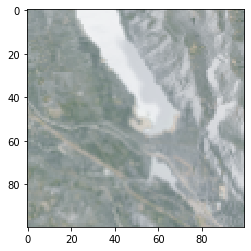

In [38]:
imgseg.plot_image_rgb()

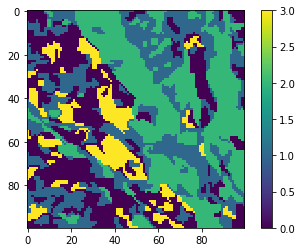

In [39]:
imgseg.plot_groups()

# Incoorporate these later. 

In [ ]:
        
    def segment_slic(self,n_segments=250, compactness=10, sigma=1):
        
        # our gdal import array is (z,y,x) we need the data in (y,x,z). Where x=long, y=lat, z=color 
        
        analysis_img = np.swapaxes(self.imgarr,0,2)
        analysis_img = np.swapaxes(self.imgarr,0,1)
        self.image_reshaped = analysis_img
        analysis_img = analysis_img[:][:][:2]
        self.segmentation = slic(self.analysis_img, n_segments=n_segments, compactness=compactness, sigma=sigma)
        self.segmentation_type = 'slic'
        
    def segment_quickshift(self,kernel_size=3, max_dist=6, ratio=0.5):
                # our gdal import array is (z,y,x) we need the data in (y,x,z). Where x=long, y=lat, z=color 
        
        analysis_img = np.swapaxes(self.imgarr,0,2)
        #analysis_img = np.swapaxes(self.imgarr,0,1)
        self.image_reshaped = analysis_img
        self.analysis_img = analysis_img[:][:][:2]
        self.segmentation = quickshift(self.analysis_img, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio)
        self.segmentation_type = 'quickshift'
        
    def segment_watershed(self,markers=250, compactness=0.001):
        
        analysis_img = np.swapaxes(self.imgarr,0,2)
        #analysis_img = np.swapaxes(self.imgarr,0,1)
        self.image_reshaped = analysis_img
        analysis_img = analysis_img[:][:][:2]
        
        gradient = sobel(rgb2gray(self.analysis_img))
        self.segmentation = watershed(gradient, markers=markers, compactness=compactness)
        self.segmentation_type = 'watershed'